![image](https://docs.google.com/uc?export=download&id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d)

<h1><center><b>Segmentación Semántica y Arquitecturas de Segmentación</b></center></h1>
<h3><center><b>IMÁGENES Y VISIÓN</b></center></h3>


## **Contenido**
1. [**Objetivos**](#id1)
2. [**Problema**](#id2)
3. [**Importando las librerías necesarias para el laboratorio**](#id3)
4. [**Visualización y Análisis Exploratorio**](#id4)
5. [**Preparación de los Datos**](#id5)
6. [**Modelamiento**](#id6)
    - [**Auntoencoder**](#id6-1)
    - [**U-Net**](#id6-2)
7. [**Validación**](#id7)
8. [**Extracción de Características**](#id8)

## **Objetivos**<a name="id1"></a>
- Familiarizarse con el entrenamiento de bajo-nivel
- Conocer arquitecturas de segmentación tales como el Autoencoder y U-Net
- Conocer PyTorch como alternativa a TensorFlow.
- Visualizar modelos usando TensorBoard
- Conocer más patrones de aprendizaje.
- Extraer características de región

## **Problema**
- En un dataset de tomografías axiales computarizadas (TAC) de abdomen, hay varios pacientes con tumores en sus riñones, la idea es detectarlos utilizando inteligencia artificial.

## **Notebook Configuration**

In [ ]:
!shred -u setup_colab.py
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_workshop_13()

shred: setup_colab.py: failed to open for writing: No such file or directory
shred: setup_colab_general.py: failed to open for writing: No such file or directory



General Functions Enabled Successfully
Libraries Installed!



Util Functions Downloaded Successfully




Extracting Zip File...
Deleting File...




Extracting Zip File...
Deleting File...
Dataset Downloaded Successfully



Pretrained Networks Downloaded Successfully
Workshop 13 Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**<a name="id3"></a>

In [ ]:
# Basic Data Analysis Libraries
import numpy as np
import pandas as pd

# Basic OS Libraries
import copy
import os

# Basic Graphic Functions
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

# Util Functions
from utils import general as gen
from utils import torch_utils
from utils import visualization_utils as vis
from utils import train_utils

# Loaders
from tqdm.auto import tqdm

# Data Augmentation Libraries
import albumentations as A

# PyTorch Libraries
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/KiTS')
%load_ext tensorboard

# Torchvision Functions
from torchvision.transforms.functional import to_tensor

# Summary Functions
from torchsummary import summary

# Dataset Creation and Splitting Functions
from sklearn.model_selection import ShuffleSplit
from torch.utils.data import Dataset, DataLoader, Subset

# Computer Vision Libraries
import cv2

# Image Processing Libraries
from skimage import measure

# Scikit-Learn Libraries
from sklearn.cluster import KMeans

### **Carga de Datos**

In [ ]:
train_dir = gen.create_and_verify(".", "data", "train_data", list_=True)

In [ ]:
train_data_dir = gen.read_listdir(train_dir[0])
train_labels_dir = gen.read_listdir(train_dir[1])

In [ ]:
print(train_data_dir)

['./data/train_data/data/X_0.npy' './data/train_data/data/X_1.npy'
 './data/train_data/data/X_10.npy' ... './data/train_data/data/X_997.npy'
 './data/train_data/data/X_998.npy' './data/train_data/data/X_999.npy']


## **Visualización y Análisis Exploratorio**<a name="id4"></a>
- En esta ocasión vamos a trabajar con el dataset de Kidney Tumor Segmentation donde vamos a detectar tumores en riñón usando segmentación semántica.
- Escala Hounsfield

![image](http://1.bp.blogspot.com/-apELBiPpN0g/UCa1sYUjT9I/AAAAAAAAABc/BcFCZE_eHbg/s400/4a11f2.jpg)

> Tomado de http://modulotecguana.blogspot.com/2012/08/la-escala-de-hounsfield.html

In [ ]:
np.random.seed(1999)
random_sample = np.random.choice(range(len(train_data_dir)), 3)
random_sample

array([ 259, 5228, 7787])

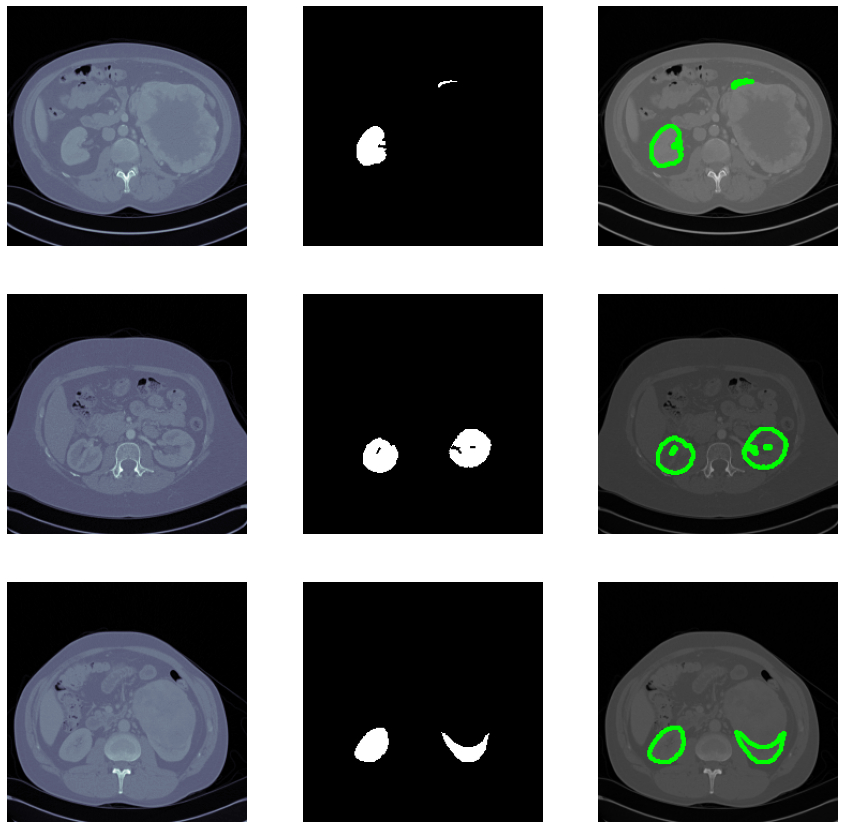

In [ ]:
plt.figure(figsize=(15, 15))

index = 1
for i in random_sample:
    path2img = train_data_dir[i]
    path2lab = train_labels_dir[i]
    
    X = np.load(path2img)
    y = np.load(path2lab)[..., 0]
    labeled_X = vis.get_labeled_image(X, y, (0, 1, 0), 
                                      (0, 1, 0), "thick")

    plt.subplot(3, 3, index)
    gen.imshow(X, color=False, cmap="bone")

    plt.subplot(3, 3, index+1)
    gen.imshow(y, color=False)

    plt.subplot(3, 3, index+2)
    gen.imshow(labeled_X)

    index += 3

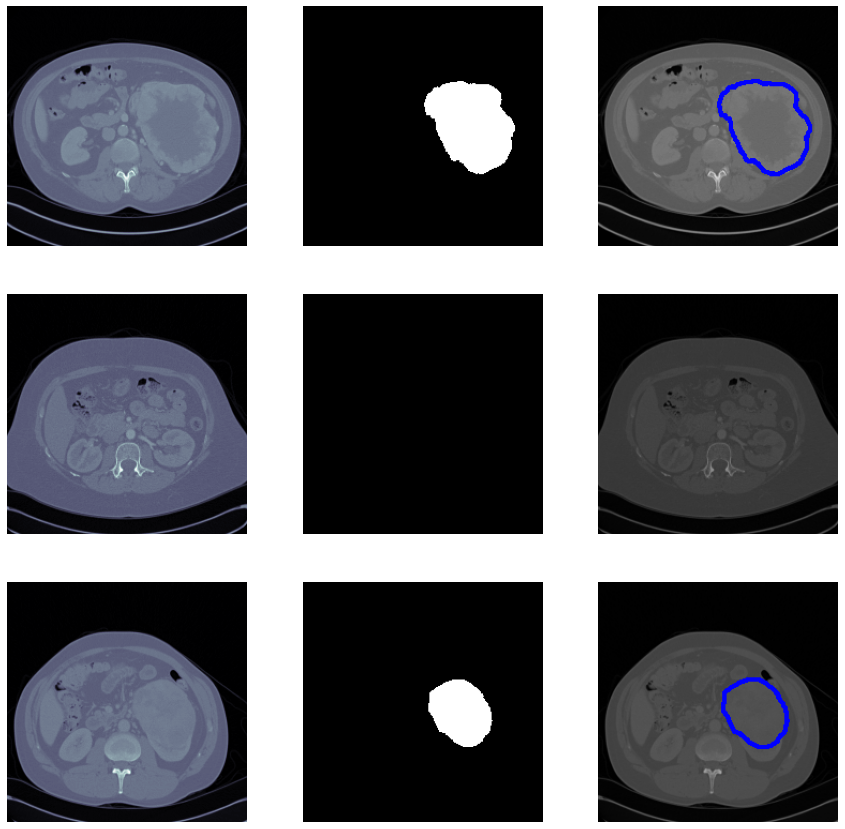

In [ ]:
plt.figure(figsize=(15, 15))

index = 1
for i in random_sample:
    path2img = train_data_dir[i]
    path2lab = train_labels_dir[i]
    
    X = np.load(path2img)
    y = np.load(path2lab)[..., 1]
    labeled_X = vis.get_labeled_image(X, y, (0, 0, 1), 
                                      (0, 0, 1), "thick")

    plt.subplot(3, 3, index)
    gen.imshow(X, color=False, cmap="bone")

    plt.subplot(3, 3, index+1)
    gen.imshow(y, color=False)

    plt.subplot(3, 3, index+2)
    gen.imshow(labeled_X)

    index += 3

## **Preparación de los Datos**<a name="id5"></a>

In [ ]:
transform_train = A.Compose([
    A.Resize(128, 128),
    A.RandomBrightness(p=0.8),
    A.RandomGamma(p=0.65),
    A.RandomContrast(p=0.7),
    A.VerticalFlip(p=0.7)
])

# Stage 2
# transform_train = A.Resize(128, 128)

transform_val = A.Resize(128, 128)

In [ ]:
class KidneyDataset(Dataset):
    def __init__(self, path2data, transform=None, *args, **kwargs):
        self.data_dir = gen.read_listdir(path2data[0])
        self.labels_dir = gen.read_listdir(path2data[1])

        self.transform = transform

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, index):
        path2img = self.data_dir[index]
        path2lab = self.labels_dir[index]

        X = np.load(path2img)
        y = np.load(path2lab)

        if self.transform:
            augmented = self.transform(image=X, mask=y)
            X = augmented["image"]
            y = augmented["mask"]
        X = to_tensor(X)
        y = 255. * to_tensor(y)
        return X, y

In [ ]:
kidney_ds1 = KidneyDataset(train_dir, transform=transform_train)
kidney_ds2 = KidneyDataset(train_dir, transform=transform_val)

In [ ]:
X, y = kidney_ds1[259]

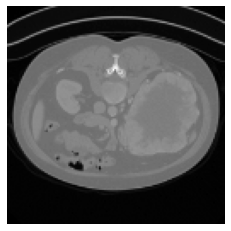

In [ ]:
gen.imshow(X[0], color=False)

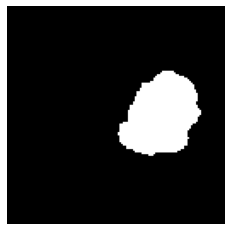

In [ ]:
gen.imshow(y[1], color=False)

In [ ]:
ss_data = ShuffleSplit(n_splits=2, test_size=0.2, random_state=1234)

In [ ]:
indices = range(len(kidney_ds1))

In [ ]:
for train_index, val_index in ss_data.split(indices):
    pass

In [ ]:
train_data = Subset(kidney_ds1, train_index)
val_data = Subset(kidney_ds2, val_index)

In [ ]:
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=16)

## **Modelamiento**<a name="id6"></a>

- En este laboratorio vamos a modelar dos arquitecturas neuronales para segmentación semántica.

![image](https://docs.google.com/uc?export=download&id=1XAMvojRsVynBrqwcYLZgwzOnaFvmP2vc)

![image](https://docs.google.com/uc?export=download&id=1p1aDB6jtU9MDs25PiIwoDUjvYezc2llR)

> Tomado de: Atienza, R., 2020. *Advanced Deep Learning With Tensorflow 2 And Keras*. (513 pages) 2nd ed. United Kingdom: Packt Publishing.
### **Auntoencoder**<a name="id6-1"></a>
![image](https://miro.medium.com/max/1000/0*uq2_ZipB9TqI9G_k)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained = False

In [ ]:
model = torch_utils.Autoencoder(1, 2, 16, 4, bn=True, jump=2)

model = model.to(device)

In [ ]:
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         LeakyReLU-3         [-1, 16, 128, 128]               0
         ConvBlock-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
       BatchNorm2d-6         [-1, 32, 128, 128]              64
         LeakyReLU-7         [-1, 32, 128, 128]               0
         ConvBlock-8         [-1, 32, 128, 128]               0
         MaxPool2d-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          18,496
      BatchNorm2d-11           [-1, 64, 64, 64]             128
        LeakyReLU-12           [-1, 64, 64, 64]               0
        ConvBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,

In [ ]:
writer.add_graph(model, torch.rand((2, 1, 128, 128)).to(device))
writer.close()

In [ ]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 678), started 0:32:23 ago. (Use '!kill 678' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
lr = 5e-3

if pretrained:
    weights_dir = gen.create_and_verify(".", "models", "autoencoder.pt")
    model.load_state_dict(torch.load(weights_dir))
    lr = 8e-4
    print("Weights Loaded")

#### **Training**<a name="id6-1-1"></a>

In [ ]:
opt = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                 patience=6, verbose=1)

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

weights_dir= "models/"

args_train = (
    20, train_utils.loss_func, opt, train_dl, val_dl, False,
    lr_scheduler, weights_dir + "weights.pt", device
)

kwargs_train = {
    "metric": train_utils.jaccard,
    "best_loss": 0.1261334,
    "best_acc": 89.61
}

In [ ]:
out_model, loss_history, acc_history = train_utils.train(model, *args_train,
                                                         **kwargs_train)


Train Loss: 1.497845, Accuracy: 2.03
Val loss: 1.331053, Accuracy: 2.46
--------------------------------------------------



Train Loss: 1.219997, Accuracy: 4.41
Val loss: 1.144454, Accuracy: 3.43
--------------------------------------------------



Train Loss: 1.046564, Accuracy: 10.05
Val loss: 1.002854, Accuracy: 10.49
--------------------------------------------------



Train Loss: 0.914091, Accuracy: 17.62
Val loss: 0.848598, Accuracy: 22.37
--------------------------------------------------



Train Loss: 0.795343, Accuracy: 26.92
Val loss: 0.772290, Accuracy: 29.73
--------------------------------------------------



Train Loss: 0.709498, Accuracy: 34.50
Val loss: 0.696267, Accuracy: 35.14
--------------------------------------------------



Train Loss: 0.643189, Accuracy: 40.09
Val loss: 0.640167, Accuracy: 40.11
--------------------------------------------------



Train Loss: 0.602297, Accuracy: 43.64
Val loss: 0.608792, Accuracy: 43.34
--------------------------------------------------



Train Loss: 0.569760, Accuracy: 46.46
Val loss: 0.565147, Accuracy: 47.08
--------------------------------------------------



Train Loss: 0.542196, Accuracy: 48.80
Val loss: 0.571012, Accuracy: 46.97
--------------------------------------------------



Train Loss: 0.517455, Accuracy: 50.99
Val loss: 0.543234, Accuracy: 49.10
--------------------------------------------------



Train Loss: 0.501173, Accuracy: 52.49
Val loss: 0.512043, Accuracy: 51.75
--------------------------------------------------



Train Loss: 0.483809, Accuracy: 54.06
Val loss: 0.510264, Accuracy: 52.28
--------------------------------------------------



Train Loss: 0.473996, Accuracy: 54.93
Val loss: 0.511265, Accuracy: 52.68
--------------------------------------------------



Train Loss: 0.464240, Accuracy: 55.89
Val loss: 0.478695, Accuracy: 54.50
--------------------------------------------------



Train Loss: 0.450853, Accuracy: 56.99
Val loss: 0.470043, Accuracy: 55.24
--------------------------------------------------



Train Loss: 0.444598, Accuracy: 57.53
Val loss: 0.467497, Accuracy: 55.64
--------------------------------------------------



Train Loss: 0.435689, Accuracy: 58.29
Val loss: 0.480091, Accuracy: 55.76
--------------------------------------------------



Train Loss: 0.429133, Accuracy: 58.84
Val loss: 0.452853, Accuracy: 56.63
--------------------------------------------------



Train Loss: 0.426956, Accuracy: 59.07
Val loss: 0.440889, Accuracy: 57.92
--------------------------------------------------



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd "/gdrive/My Drive/Datasets Limpios/KiTS/models"
!cp /content/models/weights.pt .
%cd /content

[Errno 2] No such file or directory: '/gdrive/My Drive/Datasets Limpios/KiTS/models'
/content
cp: cannot stat '/content/models/weights.pt': No such file or directory
/content


#### **Predicción**<a name="id6-1-2"></a>

In [ ]:
weights_dir = gen.create_and_verify(".", "models", "autoencoder.pt")

model.load_state_dict(torch.load(weights_dir))
model = model.eval().to(device)

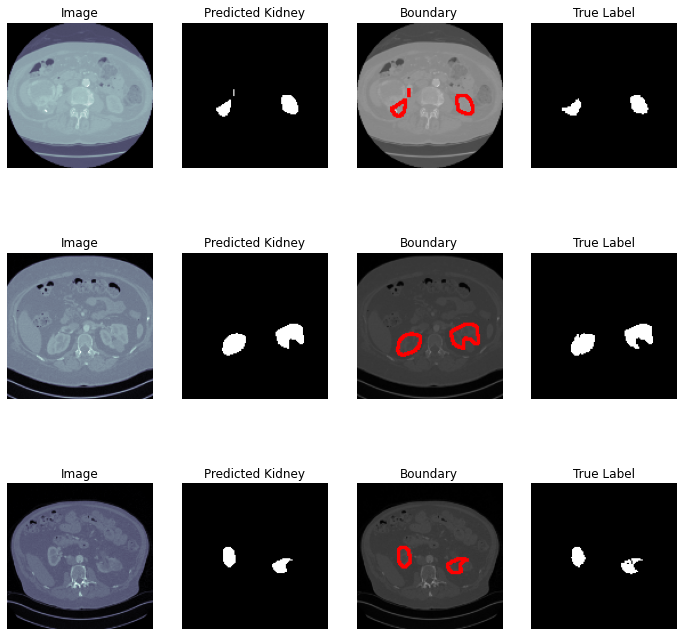

In [ ]:
vis.predict(model, device, val_data, mode="inner", 
            random_state=2020)

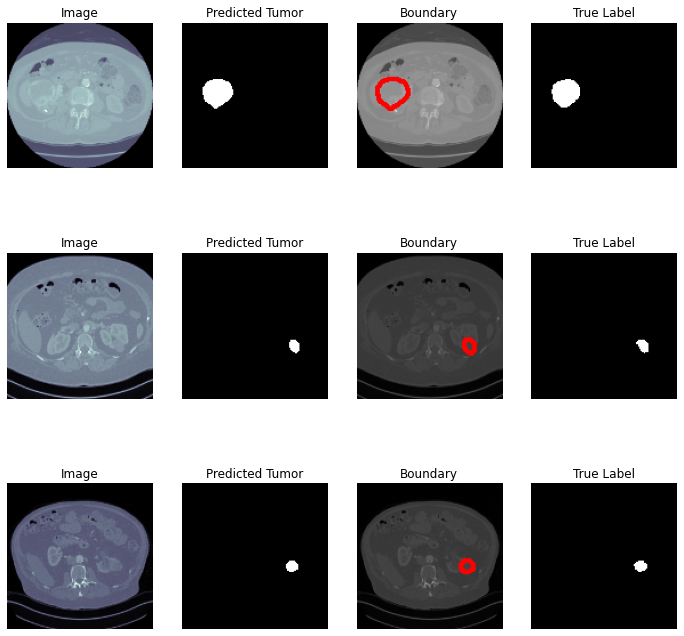

In [ ]:
vis.predict(model, device, val_data, class_="tumor", mode="thick", 
            random_state=2020)

### **U-Net**<a name="id6-2"></a>
![image](https://www.researchgate.net/profile/Olaf_Ronneberger/publication/276923248/figure/fig4/AS:639578838929408@1529498886425/U-net-architecture-example-for-32x32-pixels-in-the-lowest-resolution-Each-blue-box.png)

In [ ]:
model = torch_utils.UNet(1, 2, 16, 5, bn=True, jump=2)

model = model.to(device)

In [ ]:
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         LeakyReLU-3         [-1, 16, 128, 128]               0
         ConvBlock-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
       BatchNorm2d-6         [-1, 32, 128, 128]              64
         LeakyReLU-7         [-1, 32, 128, 128]               0
         ConvBlock-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 32, 128, 128]           9,248
      BatchNorm2d-10         [-1, 32, 128, 128]              64
        LeakyReLU-11         [-1, 32, 128, 128]               0
        ConvBlock-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]           9,248
      BatchNorm2d-14         [-1, 32, 1

In [ ]:
writer.add_graph(model, torch.rand((2, 1, 128, 128)).to(device))
writer.close()

In [ ]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 678), started 0:50:20 ago. (Use '!kill 678' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
lr = 5e-3

if pretrained:
    weights_dir = gen.create_and_verify(".", "models", "unet.pt")
    model.load_state_dict(torch.load(weights_dir))
    lr = 8e-4
    print("Weights Loaded")

#### **Training**<a name="id6-2-1"></a>

In [ ]:
opt = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                 patience=6, verbose=1)

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

weights_dir= "models/"

args_train = (
    20, train_utils.loss_func, opt, train_dl, val_dl, False,
    lr_scheduler, weights_dir + "weights.pt", device
)

kwargs_train = {
    "metric": train_utils.jaccard,
    "best_loss": 0.090871,
    "best_acc": 91.77
}

In [ ]:
out_model, loss_history, acc_history = train_utils.train(model, *args_train,
                                                         **kwargs_train)


Train Loss: 1.483741, Accuracy: 2.55
Val loss: 1.369313, Accuracy: 3.43
--------------------------------------------------



Train Loss: 1.178290, Accuracy: 6.53
Val loss: 1.087563, Accuracy: 8.99
--------------------------------------------------



Train Loss: 1.001717, Accuracy: 12.84
Val loss: 0.946467, Accuracy: 16.95
--------------------------------------------------



Train Loss: 0.856778, Accuracy: 22.40
Val loss: 0.803465, Accuracy: 27.39
--------------------------------------------------



Train Loss: 0.733605, Accuracy: 32.94
Val loss: 0.697247, Accuracy: 36.28
--------------------------------------------------



Train Loss: 0.647649, Accuracy: 40.49
Val loss: 0.644982, Accuracy: 41.31
--------------------------------------------------



Train Loss: 0.590624, Accuracy: 45.44
Val loss: 0.635592, Accuracy: 44.93
--------------------------------------------------



Train Loss: 0.551409, Accuracy: 48.90
Val loss: 0.566983, Accuracy: 47.21
--------------------------------------------------



Train Loss: 0.521813, Accuracy: 51.32
Val loss: 0.551290, Accuracy: 50.15
--------------------------------------------------



Train Loss: 0.498644, Accuracy: 53.20
Val loss: 0.524552, Accuracy: 50.75
--------------------------------------------------



Train Loss: 0.480300, Accuracy: 54.70
Val loss: 0.508648, Accuracy: 52.69
--------------------------------------------------



Train Loss: 0.465645, Accuracy: 55.91
Val loss: 0.484729, Accuracy: 53.91
--------------------------------------------------



Train Loss: 0.453528, Accuracy: 56.92
Val loss: 0.497143, Accuracy: 53.54
--------------------------------------------------



Train Loss: 0.443737, Accuracy: 57.73
Val loss: 0.456930, Accuracy: 56.53
--------------------------------------------------



Train Loss: 0.435690, Accuracy: 58.42
Val loss: 0.450263, Accuracy: 57.03
--------------------------------------------------



Train Loss: 0.428969, Accuracy: 59.00
Val loss: 0.443449, Accuracy: 57.83
--------------------------------------------------



Train Loss: 0.419705, Accuracy: 59.74
Val loss: 0.443279, Accuracy: 57.88
--------------------------------------------------



Train Loss: 0.414937, Accuracy: 60.14
Val loss: 0.431443, Accuracy: 58.82
--------------------------------------------------



Train Loss: 0.409851, Accuracy: 60.57
Val loss: 0.429849, Accuracy: 58.97
--------------------------------------------------



Train Loss: 0.404543, Accuracy: 60.98
Val loss: 0.418316, Accuracy: 59.70
--------------------------------------------------



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd "/gdrive/My Drive/Datasets Limpios/KiTS/models"
!cp /content/models/weights.pt .
%cd /content

[Errno 2] No such file or directory: '/gdrive/My Drive/Datasets Limpios/KiTS/models'
/content
cp: cannot stat '/content/models/weights.pt': No such file or directory
/content


#### **Predicción**<a name="id6-2-2"></a>

In [ ]:
weights_dir = gen.create_and_verify(".", "models", "unet.pt")

model.load_state_dict(torch.load(weights_dir))
model = model.eval().to(device)

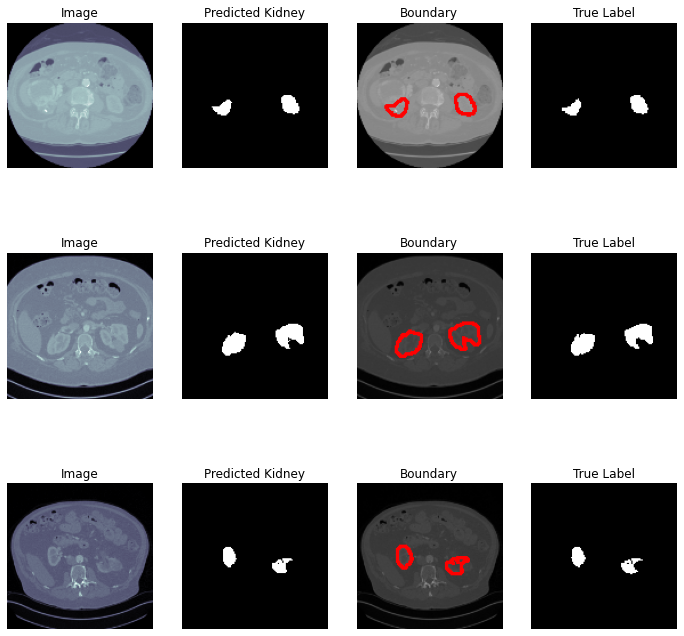

In [ ]:
vis.predict(model, device, val_data, 
            random_state=2020)

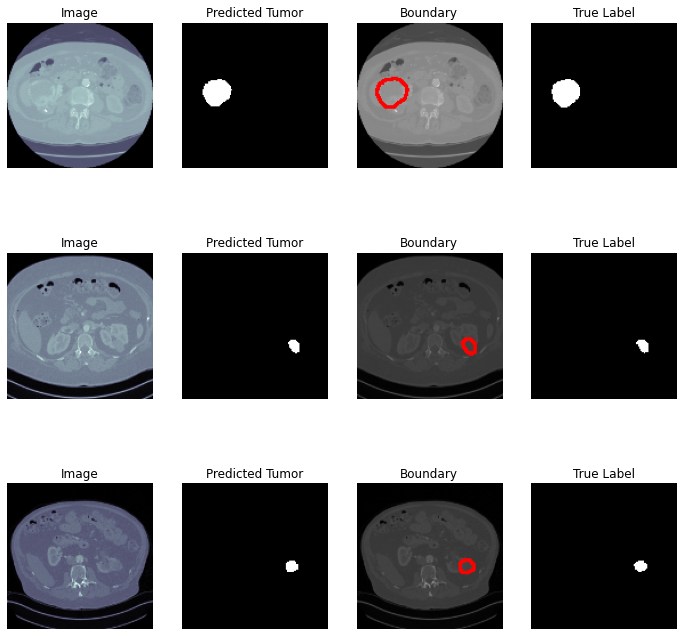

In [ ]:
vis.predict(model, device, val_data, class_="tumor", 
            random_state=2020)

## **Validación**<a name="id7"></a>

In [ ]:
test_dir = gen.create_and_verify(".", "data", "test_data", list_=True)

In [ ]:
test_ds = KidneyDataset(test_dir, transform=transform_val)
test_dl = DataLoader(test_ds, batch_size=16)

### **Autoencoder**<a name="id7-1"></a>

In [ ]:
model = torch_utils.Autoencoder(1, 2, 16, 4, bn=True, jump=2)

weights_dir = gen.create_and_verify(".", "models", "autoencoder.pt")

model.load_state_dict(torch.load(weights_dir))
model = model.eval().to(device)

In [ ]:
train_utils.evaluate(model, train_utils.loss_func, test_dl, device, 
                     sanity_check=False)

(0.3378130509594425, 0.7152129323756109)

### **U-Net** <a name="id7-2"></a>

In [ ]:
model = torch_utils.UNet(1, 2, 16, 5, bn=True, jump=2)

weights_dir = gen.create_and_verify(".", "models", "unet.pt")

model.load_state_dict(torch.load(weights_dir))
model = model.eval().to(device)

In [ ]:
train_utils.evaluate(model, train_utils.loss_func, test_dl, device, 
                     sanity_check=False)

(0.3554551962946282, 0.6926433258369321)

## **Extracción de Características**<a name="id8"></a>
- Extraer características, en este caso, nos va a ser muy útil para saber qué hacer con un tumor de riñón.

In [ ]:
test_generator = train_utils.SimpleGenerator(test_dir)

In [ ]:
kidney_data = np.zeros((len(test_generator), 224, 224), dtype="uint8")
tumor_data = np.zeros((len(test_generator), 224, 224), dtype="uint8")

In [ ]:
index = 0
for X, y in tqdm(test_generator):
    kidney_data[index] = X
    tumor_data[index] = y[..., 1]
    index += 1

In [ ]:
random_choice = np.random.choice(len(test_generator), 100)

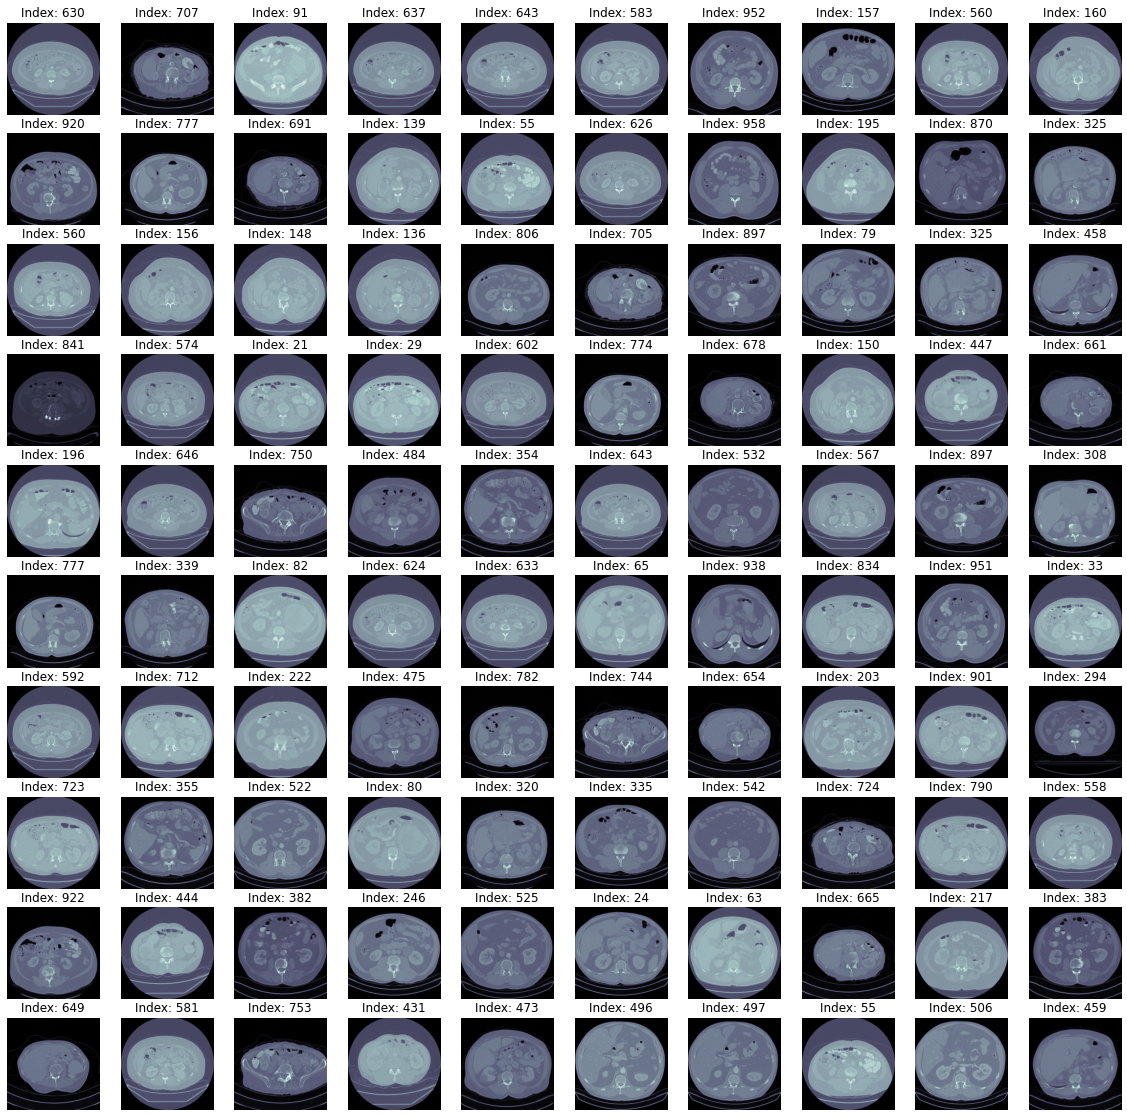

In [ ]:
plt.figure(figsize=(20, 20))

index = 1
for i in random_choice:
    plt.subplot(10, 10, index)
    gen.imshow(kidney_data[i], color=False, 
               title=f"Index: {i}", cmap="bone")

    index += 1

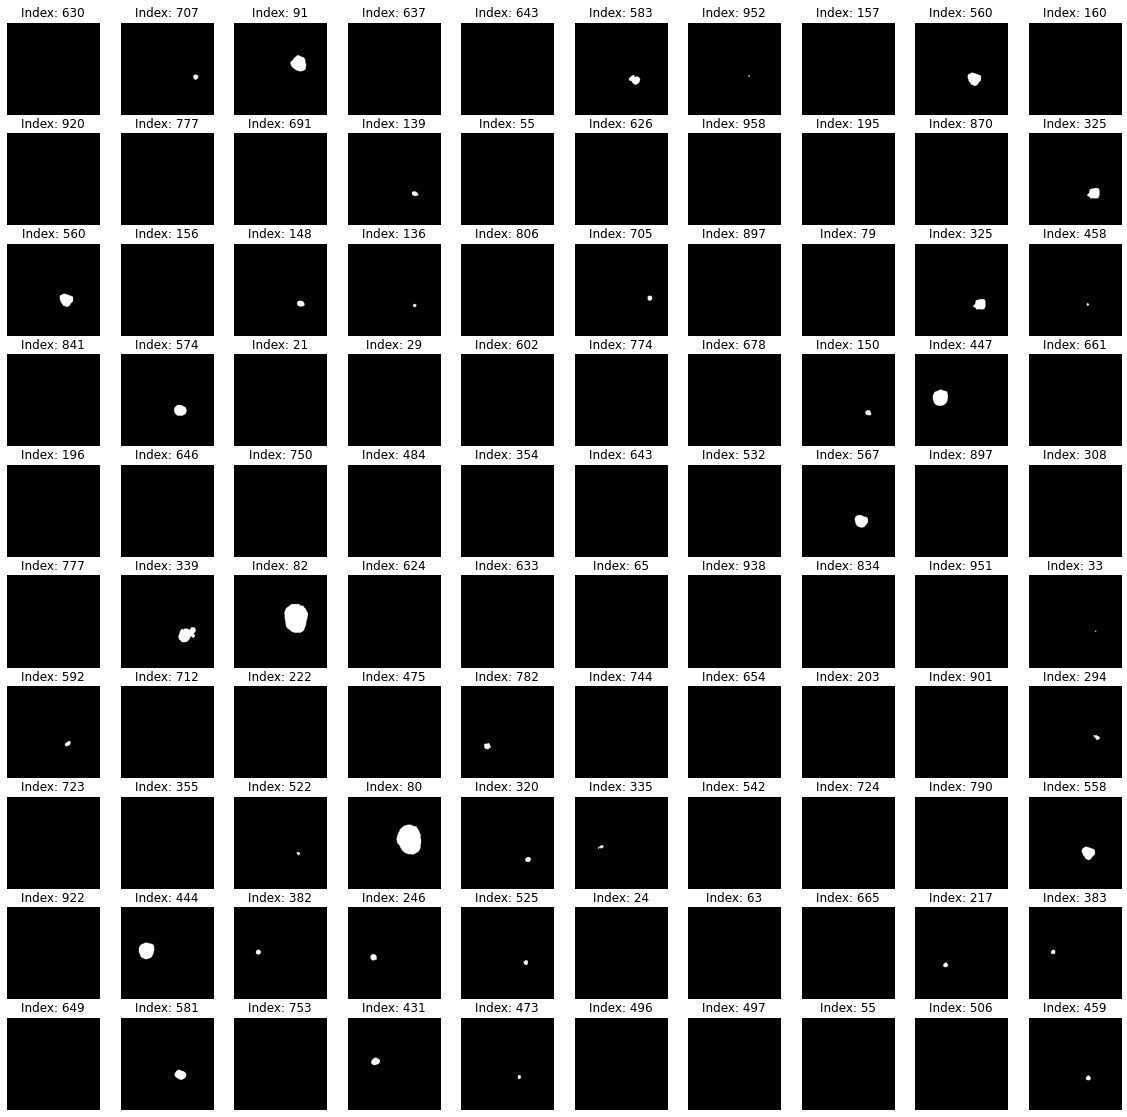

In [ ]:
plt.figure(figsize=(20, 20))

index = 1
for i in random_choice:
    plt.subplot(10, 10, index)
    gen.imshow(tumor_data[i], color=False, 
               title=f"Index: {i}")

    index += 1

In [ ]:
segmentation_data = np.zeros((len(test_generator), 224, 224))

In [ ]:
for i in range(kidney_data.shape[0]):
    segmentation_data[i] = kidney_data[i] * tumor_data[i]

In [ ]:
data_dict = {
    "Area/Mass": [measure.moments(array, 0)[0, 0] for 
                  array in segmentation_data],
    "Rugosity": [vis.rugosity(array) for array in segmentation_data]
}

In [ ]:
data = pd.DataFrame(data_dict)

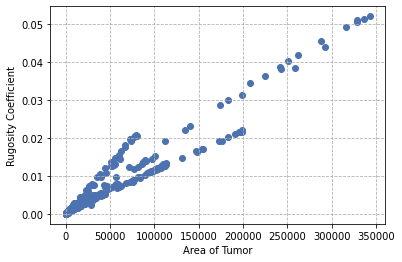

In [ ]:
plt.scatter(x=data["Area/Mass"], y=data["Rugosity"])
plt.xlabel("Area of Tumor")
plt.ylabel("Rugosity Coefficient")
plt.grid(linestyle="--")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, n_jobs=-1, random_state=1234)

In [ ]:
kmeans = kmeans.fit(data)

In [ ]:
centroids = kmeans.predict(data)

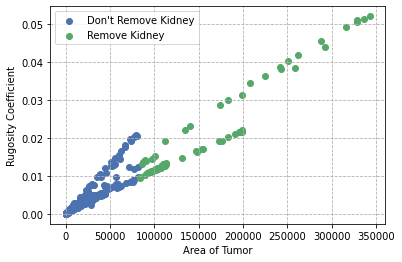

In [ ]:
plt.scatter(x=data["Area/Mass"][centroids==0], 
            y=data["Rugosity"][centroids==0], 
            label="Don't Remove Kidney")
plt.scatter(x=data["Area/Mass"][centroids==1], 
            y=data["Rugosity"][centroids==1], 
            label="Remove Kidney")
plt.legend(loc="best")
plt.xlabel("Area of Tumor")
plt.ylabel("Rugosity Coefficient")
plt.grid(linestyle="--")
plt.show()

## **Trabajo Asíncrono**
1. Basados en el código que ya está escrito para el autoencoder, variar el parámetro `bn` y comparar resultados con los presentados en clase.
2. Nuevamente, basados en el código que ya está escrito para U-Net variar únicamente el parámetro `jump` y comparar resultados con los presentados en clase. Adicional a la métrica utilizada en clase, averiguar sobre el coeficiente de similitud [*Dice*](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), implementarlo y tomar métricas con el mismo.
3. Finalmente, tomar otros dos descriptores de los vistos en clase sobre el set de testing, construir otro modelo de clustering y hacer análisis de resultados obtenidos.

### **Punto 1**

<p align="justify">
La primera parte consistio en  modificar el hyperparámetro bn que hace referencia al batch normalization. El cual se encontraba previamente configurado en True. Es importante recordar que este parámetro, es el que permite que se normalizen las activaciones en las capaz intermedias de nuestro encoder, una tecnica que mejora generalmente el desempeño y el tiempo de entrenamiento, pues se mitiga el efecto de los gradientes inestables añadiendo una capa adiconal a la red que ayuda a a mantener una escala de valores adecuados y estandarizados. Esta capa contribuye tambien a mejorar la generalización del modelo.

Para poder evidenciar su importnaica se realizó la comparación modificando el hyperparámetro bn como False y True

In [ ]:
model = torch_utils.Autoencoder(1, 2, 16, 4, bn=False, jump=2)

model = model.to(device)

lr = 5e-3

if pretrained:
    weights_dir = gen.create_and_verify(".", "models", "autoencoder.pt")
    model.load_state_dict(torch.load(weights_dir))
    lr = 8e-4
    print("Weights Loaded")

opt = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                 patience=6, verbose=1)

if not os.path.exists("models"):
    os.makedirs("models")

weights_dir= "models/"

args_train = (
    10, train_utils.loss_func, opt, train_dl, val_dl, False,
    lr_scheduler, weights_dir + "weights.pt", device
)

kwargs_train = {
    "metric": train_utils.jaccard,
    "best_loss": 0.1261334,
    "best_acc": 89.61
}

out_model, loss_history, acc_history = train_utils.train(model, *args_train,
                                                         **kwargs_train)


Train Loss: 2.445835, Accuracy: 27.35
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Train Loss: 2.453524, Accuracy: 27.59
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Train Loss: 2.453674, Accuracy: 27.59
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Train Loss: 2.453643, Accuracy: 27.59
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Train Loss: 2.453784, Accuracy: 27.59
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Train Loss: 2.453808, Accuracy: 27.59
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Train Loss: 2.453546, Accuracy: 27.60
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Epoch     8: reducing learning rate of group 0 to 2.5000e-03.
Loading best model weights!
Train Loss: 2.453808, Accuracy: 27.59
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Train Loss: 2.437027, Accuracy: 27.05
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Train Loss: 2.453587, Accuracy: 27.59
Val loss: 2.475917, Accuracy: 27.58
--------------------------------------------------



Resultado final obtenido:


*   Training Loss: 2.4535
*   Training Accuracy: 27.59
*   Validation Loss: 2.4759
*   Training Accuracy: 27.58

El desempeño obtenido es bajo, pero por el momento solo se estan considerando 10 epocas y variaciones en la normalización del batch. Por el cambio en el número de epocas se va a volver a evaluar el modelo pero con bn=True

In [ ]:
model = torch_utils.Autoencoder(1, 2, 16, 4, bn=True, jump=2)

model = model.to(device)

lr = 5e-3

if pretrained:
    weights_dir = gen.create_and_verify(".", "models", "autoencoder.pt")
    model.load_state_dict(torch.load(weights_dir))
    lr = 8e-4
    print("Weights Loaded")

opt = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                 patience=6, verbose=1)

if not os.path.exists("models"):
    os.makedirs("models")

weights_dir= "models/"

args_train = (
    10, train_utils.loss_func, opt, train_dl, val_dl, False,
    lr_scheduler, weights_dir + "weights.pt", device
)

kwargs_train = {
    "metric": train_utils.jaccard,
    "best_loss": 0.1261334,
    "best_acc": 89.61
}

out_model, loss_history, acc_history = train_utils.train(model, *args_train,
                                                         **kwargs_train)


Train Loss: 1.502142, Accuracy: 2.34
Val loss: 1.310648, Accuracy: 1.75
--------------------------------------------------



Train Loss: 1.205996, Accuracy: 5.47
Val loss: 1.110621, Accuracy: 6.51
--------------------------------------------------



Train Loss: 1.032368, Accuracy: 10.88
Val loss: 0.966792, Accuracy: 13.67
--------------------------------------------------



Train Loss: 0.902485, Accuracy: 18.75
Val loss: 0.859083, Accuracy: 21.22
--------------------------------------------------



Train Loss: 0.788105, Accuracy: 27.99
Val loss: 0.828645, Accuracy: 29.18
--------------------------------------------------



Train Loss: 0.703363, Accuracy: 35.41
Val loss: 0.701483, Accuracy: 34.28
--------------------------------------------------



Train Loss: 0.638880, Accuracy: 40.84
Val loss: 0.633429, Accuracy: 41.89
--------------------------------------------------



Train Loss: 0.596481, Accuracy: 44.45
Val loss: 0.578179, Accuracy: 45.69
--------------------------------------------------



Train Loss: 0.562585, Accuracy: 47.32
Val loss: 0.551536, Accuracy: 47.88
--------------------------------------------------



Train Loss: 0.538850, Accuracy: 49.40
Val loss: 0.551913, Accuracy: 49.10
--------------------------------------------------



Resultado final obtenido:


*   Training Loss: 0.5388
*   Training Accuracy: 49.40
*   Validation Loss: 0.551
*   Training Accuracy: 49.10

Como podemos ver, a pesar de que el módelo no tiene un buen desempeño, se puede apreciar una mejora notoria en las metrias del desempeño, el accuracy de validación paso de un 27% a un 49%. Algo que demuestra la efectividad e importancia de hacer "batch normalization" para mejorar la convergencia y estabilidad del modelo que estamos usando en este caso, nuestro encoder.

### **Punto 2**

De nuevo, primero se procedio a evaluar el desempeño de la Unet variando el parametro de jump. A continuación se puede ver el resultado para un valor de jump de 0,2,6 y 10.



In [ ]:
model = torch_utils.UNet(1, 2, 16, 5, bn=True, jump=2)

weights_dir = gen.create_and_verify(".", "models", "unet.pt")

model.load_state_dict(torch.load(weights_dir))
model = model.eval().to(device)

In [ ]:
train_utils.evaluate(model, train_utils.loss_func, test_dl, device, 
                     sanity_check=False)

(0.3554551962946282, 0.6926433258369321)

Ahora se modificó el hyperparámetro jump de 2 a 6

In [ ]:
model = torch_utils.UNet(1, 2, 16, 5, bn=True, jump=6)

model = model.to(device)


lr = 5e-3

if pretrained:
    weights_dir = gen.create_and_verify(".", "models", "unet.pt")
    model.load_state_dict(torch.load(weights_dir))
    lr = 8e-4
    print("Weights Loaded")


opt = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                 patience=6, verbose=1)


if not os.path.exists("models"):
    os.makedirs("models")

weights_dir= "models/"

args_train = (
    20, train_utils.loss_func, opt, train_dl, val_dl, False,
    lr_scheduler, weights_dir + "weights.pt", device
)

kwargs_train = {
    "metric": train_utils.jaccard,
    "best_loss": 0.090871,
    "best_acc": 91.77
}


out_model, loss_history, acc_history = train_utils.train(model, *args_train,
                                                         **kwargs_train)


from google.colab import drive
drive.mount('/gdrive')

%cd "/gdrive/My Drive/Datasets Limpios/KiTS/models"
!cp /content/models/weights.pt .
%cd /content




Train Loss: 1.486889, Accuracy: 1.86
Val loss: 1.417253, Accuracy: 2.35
--------------------------------------------------



Train Loss: 1.231460, Accuracy: 3.73
Val loss: 1.167901, Accuracy: 5.39
--------------------------------------------------



Train Loss: 1.073121, Accuracy: 8.39
Val loss: 1.005373, Accuracy: 10.65
--------------------------------------------------



Train Loss: 0.930738, Accuracy: 16.92
Val loss: 1.097005, Accuracy: 0.92
--------------------------------------------------



Train Loss: 0.807617, Accuracy: 26.85
Val loss: 0.847540, Accuracy: 28.85
--------------------------------------------------



Train Loss: 0.719084, Accuracy: 34.42
Val loss: 0.702414, Accuracy: 35.20
--------------------------------------------------



Train Loss: 0.664135, Accuracy: 39.02
Val loss: 0.667811, Accuracy: 39.67
--------------------------------------------------



Train Loss: 0.624815, Accuracy: 42.18
Val loss: 0.645322, Accuracy: 39.70
--------------------------------------------------



Train Loss: 0.600442, Accuracy: 44.17
Val loss: 0.601402, Accuracy: 43.89
--------------------------------------------------



Train Loss: 0.575913, Accuracy: 46.17
Val loss: 0.710650, Accuracy: 33.67
--------------------------------------------------



Train Loss: 0.556413, Accuracy: 47.82
Val loss: 0.562212, Accuracy: 48.00
--------------------------------------------------



Train Loss: 0.539824, Accuracy: 49.19
Val loss: 0.578211, Accuracy: 46.24
--------------------------------------------------



Train Loss: 0.527767, Accuracy: 50.29
Val loss: 0.537353, Accuracy: 49.60
--------------------------------------------------



Train Loss: 0.512638, Accuracy: 51.53
Val loss: 0.532495, Accuracy: 49.76
--------------------------------------------------



Train Loss: 0.506187, Accuracy: 52.15
Val loss: 0.619787, Accuracy: 41.65
--------------------------------------------------



Train Loss: 0.489562, Accuracy: 53.49
Val loss: 0.495592, Accuracy: 53.11
--------------------------------------------------



Train Loss: 0.487383, Accuracy: 53.75
Val loss: 0.525009, Accuracy: 50.82
--------------------------------------------------



Train Loss: 0.477481, Accuracy: 54.61
Val loss: 0.591932, Accuracy: 46.50
--------------------------------------------------



Train Loss: 0.472608, Accuracy: 55.00
Val loss: 0.581265, Accuracy: 46.95
--------------------------------------------------



Train Loss: 0.465750, Accuracy: 55.60
Val loss: 0.475731, Accuracy: 54.59
--------------------------------------------------

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/gdrive/My Drive/Datasets Limpios/KiTS/models'
/content
cp: cannot stat '/content/models/weights.pt': No such file or directory
/content


Como se puede ver al cabo de la época 20 se obtuvieron los siguientes resultados:


*   Train Loss: 0.46
*   Train Accyracy: 55.60
*   Validation Loss: 0.4757
*   Validation Accuracy: 54.59




Ahora se procedio a cambiar el valor de por: jump =0

In [ ]:
model = torch_utils.UNet(1, 2, 16, 5, bn=True, jump=0)

model = model.to(device)


lr = 5e-3

if pretrained:
    weights_dir = gen.create_and_verify(".", "models", "unet.pt")
    model.load_state_dict(torch.load(weights_dir))
    lr = 8e-4
    print("Weights Loaded")


opt = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                 patience=6, verbose=1)


if not os.path.exists("models"):
    os.makedirs("models")

weights_dir= "models/"

args_train = (
    20, train_utils.loss_func, opt, train_dl, val_dl, False,
    lr_scheduler, weights_dir + "weights.pt", device
)

kwargs_train = {
    "metric": train_utils.jaccard,
    "best_loss": 0.090871,
    "best_acc": 91.77
}


out_model, loss_history, acc_history = train_utils.train(model, *args_train,
                                                         **kwargs_train)


from google.colab import drive
drive.mount('/gdrive')

%cd "/gdrive/My Drive/Datasets Limpios/KiTS/models"
!cp /content/models/weights.pt .
%cd /content



Train Loss: 1.468163, Accuracy: 3.59
Val loss: 1.311943, Accuracy: 4.55
--------------------------------------------------



Train Loss: 1.156979, Accuracy: 7.34
Val loss: 1.062472, Accuracy: 9.71
--------------------------------------------------



Train Loss: 0.986509, Accuracy: 13.66
Val loss: 0.982600, Accuracy: 15.19
--------------------------------------------------



Train Loss: 0.842165, Accuracy: 23.40
Val loss: 0.801634, Accuracy: 25.83
--------------------------------------------------



Train Loss: 0.713464, Accuracy: 34.17
Val loss: 0.783046, Accuracy: 33.22
--------------------------------------------------



Train Loss: 0.622064, Accuracy: 42.10
Val loss: 0.631467, Accuracy: 41.95
--------------------------------------------------



Train Loss: 0.562596, Accuracy: 47.37
Val loss: 0.654022, Accuracy: 41.26
--------------------------------------------------



Train Loss: 0.521192, Accuracy: 50.95
Val loss: 0.507387, Accuracy: 51.91
--------------------------------------------------



Train Loss: 0.491472, Accuracy: 53.53
Val loss: 0.521273, Accuracy: 51.19
--------------------------------------------------



Train Loss: 0.469685, Accuracy: 55.41
Val loss: 0.472847, Accuracy: 55.35
--------------------------------------------------



Train Loss: 0.450288, Accuracy: 57.04
Val loss: 0.526303, Accuracy: 51.76
--------------------------------------------------



Train Loss: 0.437414, Accuracy: 58.19
Val loss: 0.453484, Accuracy: 56.63
--------------------------------------------------



Train Loss: 0.425487, Accuracy: 59.25
Val loss: 0.451054, Accuracy: 56.96
--------------------------------------------------



Train Loss: 0.415843, Accuracy: 60.06
Val loss: 0.445130, Accuracy: 57.36
--------------------------------------------------



Train Loss: 0.409112, Accuracy: 60.64
Val loss: 0.425124, Accuracy: 59.19
--------------------------------------------------



Train Loss: 0.403780, Accuracy: 61.10
Val loss: 0.429878, Accuracy: 59.02
--------------------------------------------------



Train Loss: 0.401626, Accuracy: 61.31
Val loss: 0.445297, Accuracy: 57.86
--------------------------------------------------



Train Loss: 0.396444, Accuracy: 61.76
Val loss: 0.418657, Accuracy: 59.77
--------------------------------------------------



Train Loss: 0.391851, Accuracy: 62.17
Val loss: 0.441853, Accuracy: 57.83
--------------------------------------------------



Train Loss: 0.387994, Accuracy: 62.45
Val loss: 0.415306, Accuracy: 60.10
--------------------------------------------------

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/gdrive/My Drive/Datasets Limpios/KiTS/models'
/content
cp: cannot stat '/content/models/weights.pt': No such file or directory
/content


Como se puede ver al cabo de la época número 20 se obtuvieron los siguientes resultados:


*   Train Loss: 0.3879
*   Train Accyracy: 62.45
*   Validation Loss: 0.4153
*   Validation Accuracy: 60.10

Por ultimo, se modificó el valor de jump por 10

In [ ]:
model = torch_utils.UNet(1, 2, 16, 5, bn=True, jump=10)

model = model.to(device)


lr = 5e-3

if pretrained:
    weights_dir = gen.create_and_verify(".", "models", "unet.pt")
    model.load_state_dict(torch.load(weights_dir))
    lr = 8e-4
    print("Weights Loaded")


opt = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                 patience=6, verbose=1)


if not os.path.exists("models"):
    os.makedirs("models")

weights_dir= "models/"

args_train = (
    20, train_utils.loss_func, opt, train_dl, val_dl, False,
    lr_scheduler, weights_dir + "weights.pt", device
)

kwargs_train = {
    "metric": train_utils.jaccard,
    "best_loss": 0.090871,
    "best_acc": 91.77
}


out_model, loss_history, acc_history = train_utils.train(model, *args_train,
                                                         **kwargs_train)


from google.colab import drive
drive.mount('/gdrive')

%cd "/gdrive/My Drive/Datasets Limpios/KiTS/models"
!cp /content/models/weights.pt .
%cd /content



Train Loss: 1.482115, Accuracy: 1.99
Val loss: 1.322353, Accuracy: 2.32
--------------------------------------------------



Train Loss: 1.222903, Accuracy: 4.16
Val loss: 1.401193, Accuracy: 5.82
--------------------------------------------------



Train Loss: 1.054360, Accuracy: 9.61
Val loss: 0.979381, Accuracy: 12.86
--------------------------------------------------



Train Loss: 0.909829, Accuracy: 18.73
Val loss: 2.183539, Accuracy: 0.52
--------------------------------------------------



Train Loss: 0.819676, Accuracy: 26.52
Val loss: 0.836436, Accuracy: 23.53
--------------------------------------------------



Train Loss: 0.746011, Accuracy: 33.14
Val loss: 0.728438, Accuracy: 34.58
--------------------------------------------------



Train Loss: 0.683489, Accuracy: 37.91
Val loss: 0.695767, Accuracy: 37.94
--------------------------------------------------



Train Loss: 0.653657, Accuracy: 40.28
Val loss: 0.733731, Accuracy: 38.47
--------------------------------------------------



Train Loss: 0.614439, Accuracy: 43.20
Val loss: 0.606952, Accuracy: 43.60
--------------------------------------------------



Train Loss: 0.594459, Accuracy: 44.69
Val loss: 0.608781, Accuracy: 43.41
--------------------------------------------------



Train Loss: 0.578144, Accuracy: 46.06
Val loss: 0.618813, Accuracy: 43.28
--------------------------------------------------



Train Loss: 0.562442, Accuracy: 47.29
Val loss: 0.642701, Accuracy: 40.99
--------------------------------------------------



Train Loss: 0.548968, Accuracy: 48.40
Val loss: 0.553570, Accuracy: 48.02
--------------------------------------------------



Train Loss: 0.536817, Accuracy: 49.37
Val loss: 0.558188, Accuracy: 47.32
--------------------------------------------------



Train Loss: 0.532259, Accuracy: 49.73
Val loss: 0.577973, Accuracy: 46.56
--------------------------------------------------



Train Loss: 0.517176, Accuracy: 50.89
Val loss: 0.568381, Accuracy: 46.52
--------------------------------------------------



Train Loss: 0.509988, Accuracy: 51.52
Val loss: 0.553269, Accuracy: 47.87
--------------------------------------------------



Train Loss: 0.504477, Accuracy: 51.96
Val loss: 0.525194, Accuracy: 50.06
--------------------------------------------------



Train Loss: 0.493446, Accuracy: 52.88
Val loss: 0.629284, Accuracy: 42.44
--------------------------------------------------



Train Loss: 0.487979, Accuracy: 53.37
Val loss: 0.557027, Accuracy: 49.94
--------------------------------------------------

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/gdrive/My Drive/Datasets Limpios/KiTS/models'
/content
cp: cannot stat '/content/models/weights.pt': No such file or directory
/content


Como se puede ver al cabo de la época número 20 se obtuvieron los siguientes resultados:


*   Train Loss: 0.5171
*   Train Accyracy: 50.89
*   Validation Loss: 0.5683
*   Validation Accuracy: 46.52

De las pruebas realizadas se logro ver que el mejor desempeño obtenido fue cuando el hyperparámetro jump se encontraba en cero. Conforme este fue aumentando se logro notar que el desempeño de neustro modelo se fue reduciendo. 

In [ ]:
train_utils.evaluate(model, train_utils.loss_func, test_dl, device, 
                     sanity_check=False)

(1.6669123075047478, 0.01147866164349386)

In [ ]:
out_model
train_utils.SimpleGenerator

<p align="justify">
Y seguido a esto, con el fin de tener otra métrica de evaluación de nuestro modelo, se procedio a implementar el coeficiente de similitud DICE. Este coeficiente cobra una gran importancia cuando se esta trabajando en segmentación semantica como es nuestro caso. Debido, a que tenemos desbalanceo entre nuestras clases y por ejemplo la mayor parte de la imagen que estamos clasificando no va a tener tumores, puede suceder que al final tengamos un clasificador que siempre prediga que no hay tumores y tendria un buen desempeño (esto en el caso de que por ejemplo evaluaramos la catidad de pixeles que predijo bien). <br>
Para solucionar esto, se usan métricas como Jaccard Index, o el Coeficiente Dice el cual se define como 2 x el area de superposicion dividio por el número total de píxeles en ambas imágenes. El resultado de esta metrica oscilara entre 0 y 1, donde 1 es el mejor resultado.


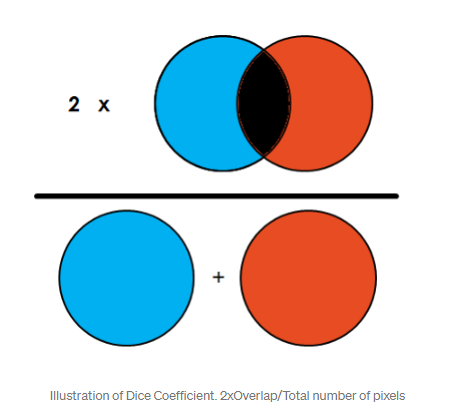

In [ ]:
model = torch_utils.UNet(1, 2, 16, 5, bn=True, jump=2)

weights_dir = gen.create_and_verify(".", "models", "unet.pt")

model.load_state_dict(torch.load(weights_dir))
model = model.eval().to(device)

In [ ]:
weights_dir = gen.create_and_verify(".", "models", "unet.pt")

model.load_state_dict(torch.load(weights_dir))
model = model.eval().to(device)


A continuación se presenta la función definida para impementar el coeficiente DICE, cuya entrada solo es la predicción y el valor real utilizando pytorch

In [ ]:
#
# Coeficiente DICE implementado 
def DICE_Metrica(pred, target):

#    pred: Entrada con la predición final del módelo
#    target: Entrada con el valor real
    smooth = 1.
    i = pred.contiguous().view(-1)
    t = target.contiguous().view(-1)
    intersect = (i * t).sum()
    A = torch.sum(i * i) 
    #A_sum = torch.sum(tflat * iflat)
    B = torch.sum(t * t)
    
    # Calculo final del coeficiente
    return 1 - ((2. * intersect + smooth) / (A + B + smooth) )

In [ ]:
train_utils.evaluate(model, train_utils.loss_func, test_dl, device, 
                     sanity_check=False)